In [14]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import EngFormatter

from mtj.init import init_m
from mtj.llg_heun import LLG_Heun
from mtj.constants import VACUUM_PERMEABILITY
from mtj.tmr import magnetization_to_resistance
from mtj.types import MaterialProps

In [2]:
def calculate_magnetization(
    m0: npt.NDArray[
        np.float64
    ],  # Initial magnetization (is normalized before simulation)
    H_app: npt.NDArray[np.float64],
    Tn=1e-10,  # (s)
    dt=1e-13,  # time step (s)
    alpha=0.008,  # Damping factor (arbitrarily chosen in this demo)
    K_u=5e5,  # Crystal anisotropy constant, default: 0
    M_s=1 / VACUUM_PERMEABILITY,  # Default: NiFe permalloy Ms (A/m)
    u_k=np.array([0, 0, 1]),  # Not used when K_0 = 0
    N=np.diag([0, 0, 1]),  # Default: "infinite" thin film
    T=0,  # Temperature (K) - H_th diabled if 0
    Vol=1e-9 * 25e-9**2 * np.pi,  # Volume
    Volt=0,  # STT voltage
    p=np.array([1, 0, 0]),  # STT polarizer orientation
    a_par=0,  # STT coefficients
    a_perp=0,
    stt_enable=False,
    recompute_H_th=False,
    recompute_H_eff=False,
):
    time_series = np.arange(0, Tn, dt)
    m = init_m(m0, len(time_series))
    params: MaterialProps = {
        "K_u": K_u,
        "M_s": M_s,
        "u_k": u_k,
        "p": p,
        "a_para": a_par,
        "a_ortho": a_perp,
        "V": Volt,
        "H_app": H_app,
        "N": N,
    }

    for i, t in enumerate(time_series[:-1]):
        # Calculate the magnetization for the next time step
        m[i + 1] = LLG_Heun(
            m[i],
            T,
            Vol,
            dt,
            alpha,
            stt_enable=stt_enable,
            recompute_H_th=recompute_H_th,
            recompute_H_eff=recompute_H_eff,
            **params,
        )

    return m, time_series

In [3]:
m, ts = calculate_magnetization(
    m0=np.array([1, 0, 0]),
    H_app=np.zeros(3),
    K_u=5.5e5,
    T=300,
    Tn=4000e-9,
    dt=1e-12,
    Vol=1e-9 * 6.5e-9**2 * np.pi,
)

[]

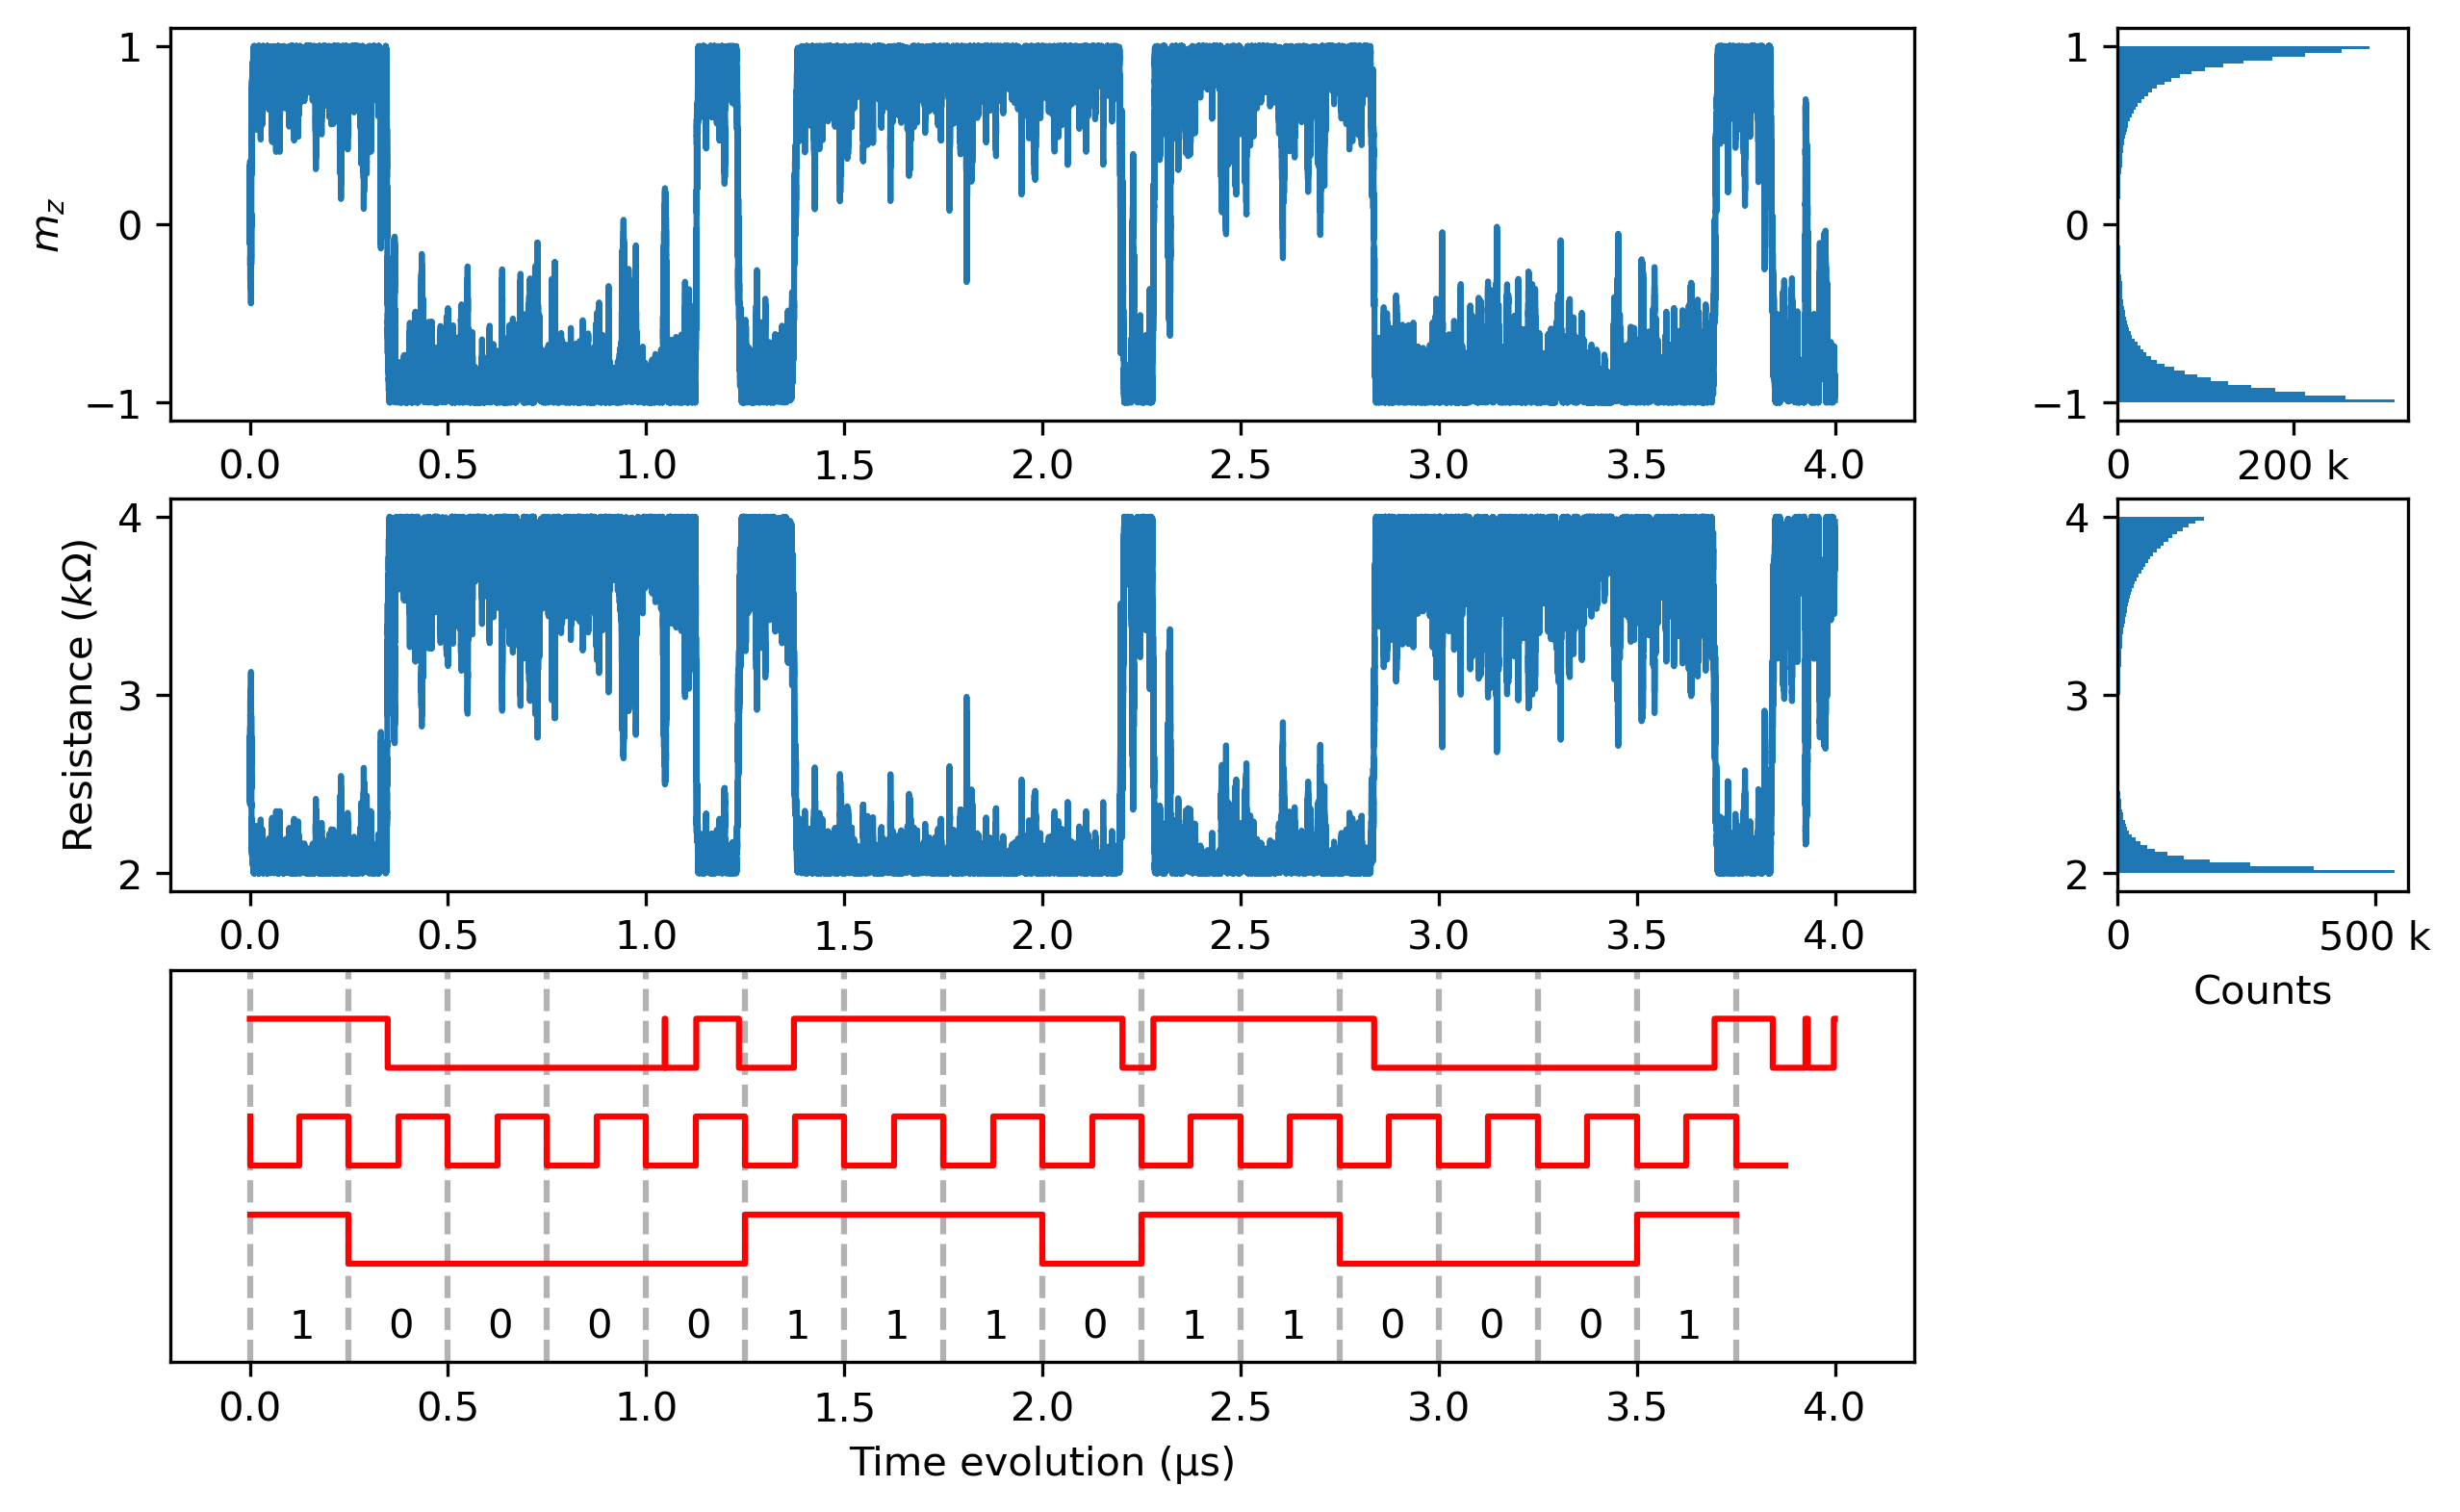

In [16]:
fig = plt.figure(figsize=(10, 6), dpi=300)
gs = GridSpec(3, 2, width_ratios=[12, 2], height_ratios=[2, 2, 2])

r = magnetization_to_resistance(m, R_P=2000, R_AP=4000)

ax1 = fig.add_subplot(gs[0])
ax1.plot(ts/1e6, m[:, 2])
ax1.set_ylabel("$m_z$")


ax3 = fig.add_subplot(gs[2])
ax3.plot(ts/1e6, r / 1000)
ax3.sharex(ax1)
ax3.set_ylabel(r"Resistance ($k\Omega$)")

ax2 = fig.add_subplot(gs[1])
ax2.hist(m[:, 2], bins=int(len(m[:, 2]) / 40000), orientation="horizontal")
ax2.xaxis.set_major_formatter(EngFormatter())
ax2.sharey(ax1)

ax4 = fig.add_subplot(gs[3])
ax4.hist(r / 1000, bins=int(len(r) / 40000), orientation="horizontal")
ax4.sharey(ax3)
ax4.xaxis.set_major_formatter(EngFormatter())
ax4.set_xlabel("Counts")

r_low = np.min(r)
r_high = np.max(r)
r_thresh = (r_high + r_low) / 2
r_smooth = np.convolve(r, np.ones(10000) / 10000, mode="same")
binary = np.where(r_smooth > r_thresh, 0, 1)

n_cycle = 16
period = len(ts) // n_cycle
clock = 1 - np.arange(n_cycle * 2) % 2
clock_ts = ts[np.arange(0, len(ts), len(ts) // (n_cycle * 2))]

ind_digi = np.arange(0, len(ts), period)
digi_ts = ts[ind_digi]
cs = binary[ind_digi]

ax5 = fig.add_subplot(gs[4])
ax5.vlines(digi_ts*1e6, -2, 6, "k", linestyles="dashed", alpha=0.3)
ax5.step(ts*1e6, binary + 4, "r")
ax5.step(clock_ts*1e6, clock + 2, "r")
ax5.step(digi_ts*1e6, cs, "r")

for i, bit in enumerate(cs[1:]):
    ax5.text(0.25*i+0.1, -1.5, str(bit))

ax5.set_xlabel("Time evolution (µs)")
ax5.set_ylim(-2, 6)
ax5.set_yticks([])